In [ ]:
# cookiecutter https://github.com/drivendata/cookiecutter-data-science

In [ ]:
import d6tpipe
api = d6tpipe.api.APIClient()

In [3]:
import category_encoders as ce
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import xgboost as xgb


In [4]:
from pathlib import Path
import os
import sys

sys.path.append(str(Path(os.getcwd()).parents[1]))
from Helper_Functions import common_utils, classification_utils
directory_to_extract_to = os.getcwd()

common_utils.load_data_from_one_drive(directory_to_extract_to, "classification_paths", "bank_marketing")

Extracting : 100%|██████████| 1/1 [00:00<00:00,  5.32it/s]


# Load the dataset

In [5]:
bank_additional_data = pd.read_csv("bank-additional-full.csv")

# Get the dataset information

In [ ]:
common_utils.get_dataset_info(bank_additional_data, show_columns=True)

Head:
   age        job  marital    education  default housing loan    contact  \
0   56  housemaid  married     basic.4y       no      no   no  telephone   
1   57   services  married  high.school  unknown      no   no  telephone   
2   37   services  married  high.school       no     yes   no  telephone   
3   40     admin.  married     basic.6y       no      no   no  telephone   
4   56   services  married  high.school       no      no  yes  telephone   

  month day_of_week  ...  campaign  pdays  previous     poutcome emp.var.rate  \
0   may         mon  ...         1    999         0  nonexistent          1.1   
1   may         mon  ...         1    999         0  nonexistent          1.1   
2   may         mon  ...         1    999         0  nonexistent          1.1   
3   may         mon  ...         1    999         0  nonexistent          1.1   
4   may         mon  ...         1    999         0  nonexistent          1.1   

   cons.price.idx  cons.conf.idx  euribor3m  nr.em

# Check the count and % of missing values

In [ ]:
common_utils.get_count_and_percentage_missing_values(bank_additional_data)

                count  % null
age                 0     0.0
job                 0     0.0
marital             0     0.0
education           0     0.0
default             0     0.0
housing             0     0.0
loan                0     0.0
contact             0     0.0
month               0     0.0
day_of_week         0     0.0
duration            0     0.0
campaign            0     0.0
pdays               0     0.0
previous            0     0.0
poutcome            0     0.0
emp.var.rate        0     0.0
cons.price.idx      0     0.0
cons.conf.idx       0     0.0
euribor3m           0     0.0
nr.employed         0     0.0
y                   0     0.0


In [ ]:
bank_additional_data['y'].value_counts()

no     36548
yes     4640
Name: y, dtype: int64

## Find the correlation of numerical columns with target value

In [ ]:
label_encoder = preprocessing.LabelEncoder()
bank_additional_data['y'] = label_encoder.fit_transform(bank_additional_data['y'])

In [ ]:
bank_additional_data['y'].value_counts()

0    36548
1     4640
Name: y, dtype: int64

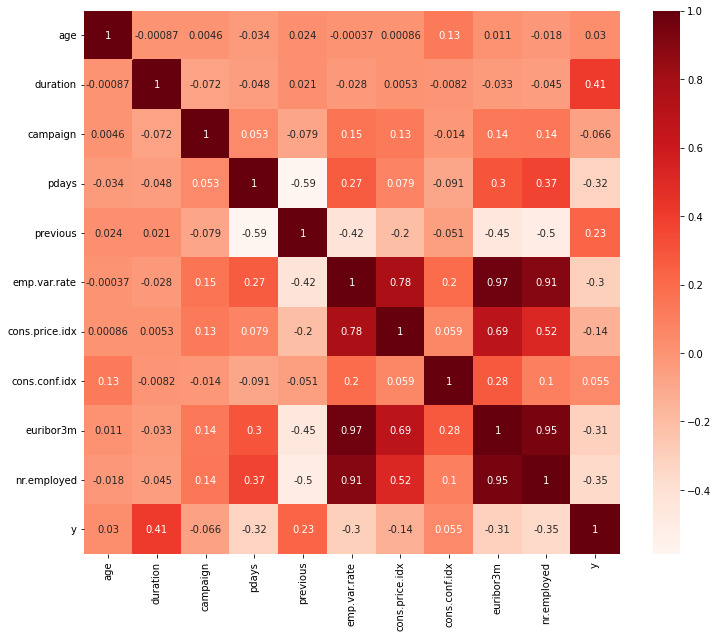

In [ ]:
plt.figure(figsize=(12,10))
cor = bank_additional_data.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

In [ ]:
#Correlation with output variable
cor_target = abs(cor["y"])
#Selecting highly correlated features
relevant_features = cor_target[cor_target>0.1]
relevant_features

duration          0.405274
pdays             0.324914
previous          0.230181
emp.var.rate      0.298334
cons.price.idx    0.136211
euribor3m         0.307771
nr.employed       0.354678
y                 1.000000
Name: y, dtype: float64

From above correlation, we can say that columns:
  * campaign
  * pdays
  * previous
  * cons.conf.idx
  * age
  
  does not majorly affect the output value 'y'
  So we can drop these columns

Lets verify the above with the help of SelectKBest method as well

# Data Pre Processing

## Apply label encoding to categorical columns
We are using categorical encoding for ordinal data

In [ ]:
categorical = ['marital', 'education', 'month', 'day_of_week', 'y']
ordinal_cols_mapping = [{
    "col": "marital",
    "mapping": {
        'unknown': 0, 'single': 1, 'married': 2, 'divorced': 3
    }}, {        
    "col": "education",
    "mapping": {
        'illiterate': 0,
        'unknown': 1,
        'basic.4y': 2,
        'basic.6y': 3,
        'basic.9y': 4,
        'high.school': 5,
        'professional.course': 6, 
        'university.degree': 7
    }}, {
    "col": "month",
    "mapping": {
        'jan': 0, 'feb': 1, 'mar': 2, 'apr': 3, 'may': 4, 'jun': 5, 'jul': 6, 'aug': 7, 'sep': 8, 'oct': 9, 'nov': 10, 'dec': 11
    }}, {
    "col": "day_of_week",
    "mapping": {
        'mon': 0, 'tue': 1, 'wed': 2, 'thu': 3, 'fri': 4
    }}
]

In [ ]:
# Subclass of Label encoder
encoder = ce.OrdinalEncoder(mapping = ordinal_cols_mapping, 
                             return_df = True)

bank_data = encoder.fit_transform(bank_additional_data)

In [ ]:
bank_data

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,2,2,no,no,no,telephone,4,0,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
1,57,services,2,5,unknown,no,no,telephone,4,0,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
2,37,services,2,5,no,yes,no,telephone,4,0,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
3,40,admin.,2,3,no,no,no,telephone,4,0,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
4,56,services,2,5,no,no,yes,telephone,4,0,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,73,retired,2,6,no,yes,no,cellular,10,4,...,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,1
41184,46,blue-collar,2,6,no,no,no,cellular,10,4,...,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,0
41185,56,retired,2,7,no,yes,no,cellular,10,4,...,2,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,0
41186,44,technician,2,6,no,no,no,cellular,10,4,...,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,1


In [ ]:
bank_data.columns

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed', 'y'],
      dtype='object')

In [ ]:
len(bank_data.columns)

21

## Feature Selection using SelectKBest

In [ ]:
# Create a copy of the dataset to get the best features
new_bank_data = bank_data.copy()
# Drop the columns to which we will apply one hot encoding later.
new_bank_data.drop(labels=['job','default','housing','loan','contact','poutcome'], axis=1, inplace=True)

In [ ]:
new_bank_data.shape

(41188, 15)

In [ ]:
# Total columns before selecting K Best
new_bank_data.columns

Index(['age', 'marital', 'education', 'month', 'day_of_week', 'duration',
       'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed', 'y'],
      dtype='object')

In [ ]:
# Apply SelectKBest
new_df_kbest = common_utils.select_k_best_features(new_bank_data, label='y', num_k=10)

/content/Helper_Functions/common_utils.py:248: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  X = df.drop([label], 1) #feature columns


In [ ]:
new_df_kbest

['marital',
 'duration',
 'campaign',
 'pdays',
 'previous',
 'emp.var.rate',
 'cons.price.idx',
 'cons.conf.idx',
 'euribor3m',
 'nr.employed']

The columns which are in new_df_kbest are the best columns which are affecting majorly on the target value.

We should drop following columns from the main dataset
* age
* education
* month
* day_of_week
* cons.conf.idx

Here, we are also removing the 'duration' because our aim is to make a realistic predictive model


In [ ]:
# Create new dataset with best features
bank_data_with_kbest = bank_data[['job', 'marital', 'default', 'housing', 'loan', 'contact',
       'campaign', 'pdays', 'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed', 'y']]

In [ ]:
bank_data_with_kbest.shape

(41188, 16)

## Apply One Hot Encoding

In [ ]:
categorical_list = ['job','default','housing','loan','contact','poutcome']

In [ ]:
bank_data_with_kbest = common_utils.get_onehotencoder(bank_data_with_kbest, categorical_list)

In [ ]:
bank_data_with_kbest.shape

(41188, 30)

In [ ]:
bank_data_with_kbest.head()

,marital,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,...,job_unknown,default_unknown,default_yes,housing_unknown,housing_yes,loan_unknown,loan_yes,contact_telephone,poutcome_nonexistent,poutcome_success
0,2,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0,...,0,0,0,0,0,0,0,1,1,0
1,2,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0,...,0,1,0,0,0,0,0,1,1,0
2,2,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0,...,0,0,0,0,1,0,0,1,1,0
3,2,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0,...,0,0,0,0,0,0,0,1,1,0
4,2,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0,...,0,0,0,0,0,0,1,1,1,0


In [ ]:
bank_data_with_kbest.columns

Index(['marital', 'campaign', 'pdays', 'previous', 'emp.var.rate',
       'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed', 'y',
       'job_blue-collar', 'job_entrepreneur', 'job_housemaid',
       'job_management', 'job_retired', 'job_self-employed', 'job_services',
       'job_student', 'job_technician', 'job_unemployed', 'job_unknown',
       'default_unknown', 'default_yes', 'housing_unknown', 'housing_yes',
       'loan_unknown', 'loan_yes', 'contact_telephone', 'poutcome_nonexistent',
       'poutcome_success'],
      dtype='object')

In [ ]:
bank_data_with_kbest['y'].value_counts()

0    36548
1     4640
Name: y, dtype: int64

## Convert pdays column to binary format and remove pdays column

In [ ]:
bank_data_with_kbest['pdays'].value_counts()

999    39673
3        439
6        412
4        118
9         64
2         61
7         60
12        58
10        52
5         46
13        36
11        28
1         26
15        24
14        20
8         18
0         15
16        11
17         8
18         7
22         3
19         3
21         2
25         1
26         1
27         1
20         1
Name: pdays, dtype: int64

As seen above, we have 39673 records with value as 999 and 1515 records with other values. 

So we will convert this column into binary values where 999 will be replaced as 0 and all other values will be replaced as 1

In [ ]:
"""
Method to create a new column based on the values inside an existing column
ref: https://stackoverflow.com/questions/48369929/creating-a-new-column-based-on-the-values-of-other-columns
df.loc[((df['Value_1'] > 1000) 
       |(df['Value_2'] > 15000)), 'High_Value_Ind'] = 'Y'

df['High_Value_Ind'] = df['High_Value_Ind'].fillna('N')
"""

bank_data_with_kbest.loc[(bank_data_with_kbest['pdays'] == 999), 'pdays_new'] = 0
bank_data_with_kbest['pdays_new'] = bank_data_with_kbest['pdays_new'].fillna(1)

In [ ]:
bank_data_with_kbest['pdays_new'].value_counts()

0.0    39673
1.0     1515
Name: pdays_new, dtype: int64

In [ ]:
bank_data_with_kbest.drop(labels=['pdays'], axis=1, inplace=True)

In [ ]:
bank_data_with_kbest.columns

Index(['marital', 'campaign', 'previous', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed', 'y', 'job_blue-collar',
       'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired',
       'job_self-employed', 'job_services', 'job_student', 'job_technician',
       'job_unemployed', 'job_unknown', 'default_unknown', 'default_yes',
       'housing_unknown', 'housing_yes', 'loan_unknown', 'loan_yes',
       'contact_telephone', 'poutcome_nonexistent', 'poutcome_success',
       'pdays_new'],
      dtype='object')

## Outlier Detection and removal

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


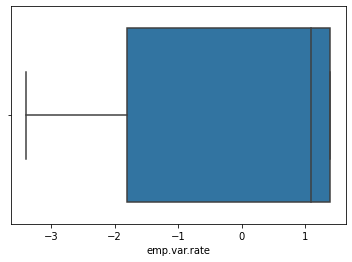

In [ ]:
sns.boxplot(bank_data_with_kbest["emp.var.rate"])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


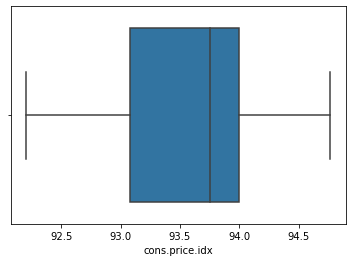

In [ ]:
sns.boxplot(bank_data_with_kbest["cons.price.idx"])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


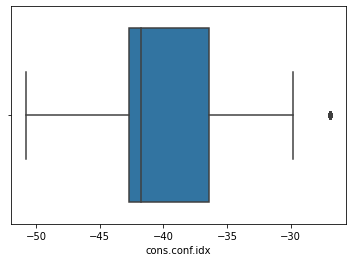

In [ ]:
sns.boxplot(bank_data_with_kbest["cons.conf.idx"])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


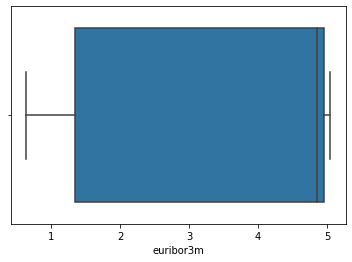

In [ ]:
sns.boxplot(bank_data_with_kbest["euribor3m"])

In [ ]:
def remove_outlier(df, col_name):
  q1 = df[col_name].quantile(0.25)
  q3 = df[col_name].quantile(0.75)
  iqr = q3-q1 #Interquartile range
  fence_low  = q1-1.5*iqr
  fence_high = q3+1.5*iqr
  df_out = df.loc[(df[col_name] > fence_low) & (df[col_name] < fence_high)]
  return df_out

In [ ]:
whole_bank_data_df = remove_outlier(bank_data_with_kbest, 'cons.conf.idx')

In [ ]:
whole_bank_data_df.shape

(40741, 30)

## Feature Scaling

In [ ]:
# Columns which require scaling: numeric columns excluding columns with binary values
numeric_columns = ['marital', 'campaign', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']
scaling_columns = common_utils.preprocess_numeric_column_data(whole_bank_data_df[numeric_columns])

In [ ]:
print(f"Columns to standarize: {scaling_columns[0]}")
print(f"Columns to normalize: {scaling_columns[1]}")

Columns to standarize: ['marital', 'cons.price.idx', 'cons.conf.idx']
Columns to normalize: ['campaign', 'previous', 'emp.var.rate', 'euribor3m', 'nr.employed']


In [ ]:
standardize_columns = ['marital', 'cons.price.idx', 'cons.conf.idx']

whole_bank_data_df[standardize_columns] = preprocessing.StandardScaler().fit_transform(whole_bank_data_df[standardize_columns])
# common_utils.standardization(bank_data_with_kbest, column_list=standardize_columns)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


In [ ]:
normalize_columns = ['campaign', 'previous', 'emp.var.rate', 'euribor3m', 'nr.employed']
whole_bank_data_df[normalize_columns] = preprocessing.MinMaxScaler().fit_transform(whole_bank_data_df[normalize_columns])
# common_utils.standardization(bank_data_with_kbest, column_list=normalize_columns)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


## Select only 5000 rows with y = 0 (No) and all rows with y = 1 (Yes) to balance the dataset

In [ ]:
balanced_bank_data_df = whole_bank_data_df.loc[whole_bank_data_df['y'] == 0]
balanced_bank_data_df = balanced_bank_data_df[:5000]
balanced_bank_data_df = balanced_bank_data_df.append(whole_bank_data_df[whole_bank_data_df['y'] == 1])
balanced_bank_data_df['y'].value_counts()

0    5000
1    4460
Name: y, dtype: int64

In [ ]:
balanced_bank_data_df.shape

(9460, 30)

## Split the dataset

### Splitting whole_bank_data_df

In [ ]:
X_whole_bank_data_df = whole_bank_data_df.drop('y', axis=1)
y_whole_bank_data_df = whole_bank_data_df['y']

# setting up testing and training sets
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X_whole_bank_data_df, y_whole_bank_data_df, test_size=0.25, random_state=27)

### Splitting balanced_bank_data_df

In [ ]:
X_balanced_bank_data_df = balanced_bank_data_df.drop('y', axis=1)
y_balanced_bank_data_df = balanced_bank_data_df['y']

# setting up testing and training sets
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_balanced_bank_data_df, y_balanced_bank_data_df, test_size=0.25, random_state=27)

In [ ]:
X_train_1.head()

,marital,campaign,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,job_blue-collar,job_entrepreneur,...,default_unknown,default_yes,housing_unknown,housing_yes,loan_unknown,loan_yes,contact_telephone,poutcome_nonexistent,poutcome_success,pdays_new
26088,-1.359723,0.072727,0.000000,0.687500,-0.681839,-0.304499,0.790297,0.877883,0,0,...,0,0,0,0,0,0,0,1,0,0.0
11741,0.282432,0.127273,0.000000,1.000000,1.539888,-0.259327,0.980503,1.000000,0,0,...,1,0,0,1,0,0,1,1,0,0.0
4135,-1.359723,0.018182,0.000000,0.937500,0.712668,0.960337,0.957606,0.859735,0,0,...,0,0,0,1,0,0,1,1,0,0.0
34826,0.282432,0.054545,0.142857,0.333333,-1.221025,-1.253126,0.143278,0.512287,0,0,...,1,0,1,0,1,0,0,0,0,0.0
24975,-1.359723,0.000000,0.000000,0.687500,-0.681839,-0.304499,0.797778,0.877883,0,0,...,0,0,0,1,0,1,0,1,0,0.0


## Type-1: XGBClassifier on original dataframe

In [ ]:
# setting up testing and training sets
X_train_t1 = X_train_1.copy()
X_test_t1 = X_test_1.copy()
y_train_t1 = y_train_1.copy()
y_test_t1 = y_test_1.copy()

In [ ]:
X_train_t1.shape, y_train_t1.shape

((30555, 29), (30555,))

In [ ]:
y_train_t1.value_counts()

0    27247
1     3308
Name: y, dtype: int64

In [ ]:
y_test_t1.value_counts()

0    9034
1    1152
Name: y, dtype: int64

In [ ]:
model_t1 = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')

In [ ]:
model_t1.fit(X_train_t1, y_train_t1)

XGBClassifier(eval_metric='mlogloss', use_label_encoder=False)

In [ ]:
y_pred_t1 = model_t1.predict(X_test_t1)

In [ ]:
accuracy_t1 = accuracy_score(y_test_t1, y_pred_t1)
print(f"The accuracy is {accuracy_t1 * 100}")

The accuracy is 90.01570783428234


In [ ]:
y_pred_t1

array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
df_result = pd.DataFrame(data={'Predictions': y_pred_t1, "Actual": y_test_t1})

In [ ]:
df_result.tail()

,Predictions,Actual
10181,0,0
10182,0,0
10183,0,0
10184,0,0
10185,0,0


In [ ]:
# y_test_t1 = y_test_t1.to_numpy()

# plt.figure(figsize=(15, 15))
# plt.plot(y_pred_t1[0:50], label='Predicted', color="blue") 
# plt.plot(y_test_t1[0:50], label='Actual', color="red") 
# plt.title("Predictions vs Actual")
# plt.legend()

## Type-2: XGBClassifier on balanced_bank_data_df dataframe

In [ ]:
# setting up testing and training sets
X_train_t2 = X_train_2.copy()
X_test_t2 = X_test_2.copy()
y_train_t2 = y_train_2.copy()
y_test_t2 = y_test_2.copy()

In [ ]:
X_train_t2.shape, y_train_t2.shape

((7095, 29), (7095,))

In [ ]:
y_train_t2.value_counts()

0    3709
1    3386
Name: y, dtype: int64

In [ ]:
y_test_t2.value_counts()

0    1291
1    1074
Name: y, dtype: int64

In [ ]:
model_t2 = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')

In [ ]:
model_t2.fit(X_train_t2, y_train_t2)

XGBClassifier(eval_metric='mlogloss', use_label_encoder=False)

In [ ]:
y_pred_t2 = model_t2.predict(X_test_t2)

In [ ]:
accuracy_t2 = accuracy_score(y_test_t2, y_pred_t2)
print(f"The accuracy is {accuracy_t2 * 100}")

The accuracy is 98.13953488372093


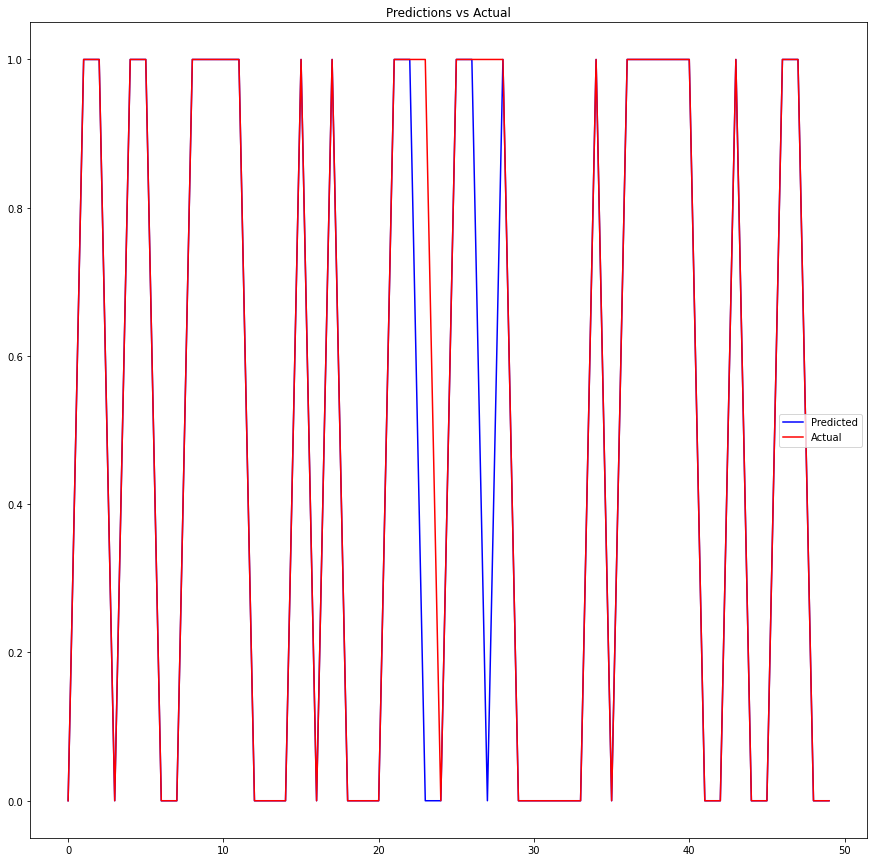

In [ ]:
y_test_t2 = y_test_t2.to_numpy()

plt.figure(figsize=(15, 15))
plt.plot(y_pred_t2[0:50], label='Predicted', color="blue") 
plt.plot(y_test_t2[0:50], label='Actual', color="red") 
plt.title("Predictions vs Actual")
plt.legend()

# Type-3: XGBClassifier with SMOTE (Synthetic Minority Oversampling Technique) on original dataframe

0: No, 1: Yes

In [ ]:
# setting up testing and training sets
X_train_t3 = X_train_1.copy()
X_test_t3 = X_test_1.copy()
y_train_t3 = y_train_1.copy()
y_test_t3 = y_test_1.copy()

In [ ]:
X_train_t3.shape, y_train_t3.shape

((30555, 29), (30555,))

In [ ]:
y_train_t3.value_counts()

0    27247
1     3308
Name: y, dtype: int64

In [ ]:
sm = SMOTE(random_state=27)
X_train_t3, y_train_t3 = sm.fit_resample(X_train_t3, y_train_t3)

In [ ]:
X_train_t3.shape, y_train_t3.shape

((54494, 29), (54494,))

In [ ]:
y_train_t3 = pd.DataFrame(y_train_t3, columns = ['y'])
y_train_t3.y.value_counts()

0    27247
1    27247
Name: y, dtype: int64

In [ ]:
model_t3 = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')

In [ ]:
model_t3.fit(X_train_t3, y_train_t3)

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


XGBClassifier(eval_metric='mlogloss', use_label_encoder=False)

In [ ]:
y_pred_t3 = model_t3.predict(X_test_t3)

In [ ]:
accuracy_t3 = accuracy_score(y_test_t3, y_pred_t3)
print(f"The accuracy is {accuracy_t3 * 100}")

The accuracy is 86.64834086000393


About SMOTE:

* Synthetic Minority Oversampling Technique
* It is an oversampling technique where the synthetic samples are generated for the minority class.
* This algorithm helps to overcome the overfitting problem posed by random oversampling
* 

TODO: 
* Read about SMOKE more
* Use hyperparameter tuning techniques for XGBoost
* Try some other algorithms.
* Plot the graph of predicted vs actual values
* Outlier:

First split and then pre process

convert to numpy array and then plot.

use stratified K-fold

Use some other models

Parameter hypertuning.